## Predicting Time Series with LSTM Deep Learning Network

### Background 
Since this is my first Time Series competition in Kaggle, I am mainly using it for learning.
There are great kernel here, mostly using the boosting models (the most popular is LightGBM 
And I have learned how to prepare the data and use it with this popular model.
Moving forwards, I have decided to learn a bit more about the use of deep learning for Time Series prediction.
I do have a background from other competition with deep learning but for image vision, working mostly with Pytorch.
To go deeper and learn the topic, I have decided to build a learning kernel, that at least at the beginning will explain the topic and the concepts, the definition and the basics, From my experience when you try to explain to others, you learn the most.

So the first kernel is only trying to explain the basic idea using an arbitrary series from the M5 data.
I hope that the next versions will go deeper and I can provide a full submission with deep learning. 
## If you like my kernel - Please Vote 

If You like this kernel 
Here a similar one with Seq2Seq model : 

https://www.kaggle.com/omershect/learning-pytorch-seq2seq-with-m5-data-set



## Versions
* Version 1-2 First Draft. 
* Version 3 Add Table Of Content.
* Version 4-7   Add Model with Multiple features
* Version 8 - Add more epochs to the Multiple features model

## Credits
The Basic data loading and the reduce memory function were taken from this great kernel 

https://www.kaggle.com/kyakovlev/m5-simple-fe

Also I have learned alot from this Pytorch LSTM kernel 
https://www.kaggle.com/gopidurgaprasad/m5-forecasting-eda-lstm-pytorch-modeling/notebook?scriptVersionId=31373530

# Table Of Contents

* [<font size=4>Main Steps</font>](#1)
* [<font size=4>Load Data</font>](#2)
* [<font size=4>One Time Series</font>](#3)
* [<font size=4>Normlize Data</font>](#4)
* [<font size=4>Create Sequances</font>](#5)
* [<font size=4>Simple LSTM model</font>](#6)
* [<font size=4>Multiple LSTM layers</font>](#7)
* [<font size=4>Add Features </font>](#8)







# Resources 
Here are some useful resources that provide some background about deep learning, Time series, and various Reuicurent Networks :

* Coursera has a course about Sequences, Time series prediction. It is a basic course that provides a preliminary overview of the concept 
  And building models to Univariate Time series. The course use Keras and TensorFlow,   but it provides a good starting point for this topic
   
   Link : https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/home/welcome
* LSTM networks - Great post/Blog that explains  the concept beyond  LSTM networks 
  
  Link : https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Post about building Time Series deep learning  - The post cover the Keras/TensorFlow framework, but it also gives a great overview of the main concepts and how to prepare the data.
  
  Link : https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* Pytorch Basic example - This is a simple example of how to build a Pytorch LSTM network for simple Univariate Time Series.
  
  Link https://github.com/pytorch/examples/tree/master/time_sequence_prediction


# Main Steps <a id="1"></a>
* These are the main steps for building a Time Series Prediction Model : 
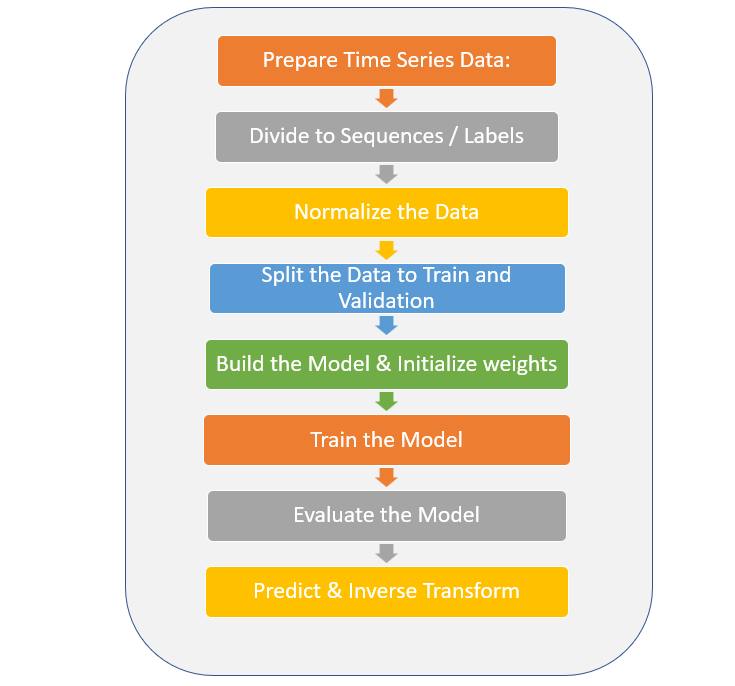

### Load Libraries

In [ ]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

 

 

## GPU use 
Since this is a deep learning model, The use of GPU will accelerate the training. 
The first models are not so demanding so you can still use CPU training (but it will be slower).

In [ ]:
device = 'cuda:0'
#device = 'cpu'

In [ ]:
INPUT_DIR_PATH = '../input/m5-forecasting-accuracy/'

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df
    

# Load Data <a id="2"></a>

In [ ]:
_,  calendar_df, sales_train_validation_df, _ = read_data()

## Date List
Here we create dates list, that will help later on to display the Time Series, with the right dates 

In [ ]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

# Select One Time Series as an Example <a id="3"></a>
Selecting one arbitrary Time Series 

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

## Plot The TS

In [ ]:
#Select arbitrary index and plot the time series
index = 6780
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


In [ ]:
#del calendar_df, sales_train_validation_df,DF_Sales
#gc.collect()

## SEED all 

In [ ]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

## Normlize Data <a id="4"></a>
Normalization is a technique often applied as part of data preparation for machine learning.
The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values.
For machine learning, every dataset does not require normalization.
It is required only when features have different rangesor scales.



Normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively

In [ ]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

If we print some of the examples, we can see that the values are now between -1 and 1 

In [ ]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

## Plot The distribution 
Plot the distribution before and after the Normalization. 
As you can see, we kept the distribution of the data, but we change its scales.

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')
   

# Create Sequances <a id="5"></a>
In this part we allign the data into input features and labels with techniches whic adapt for Time series processing 
This is out Time Series 

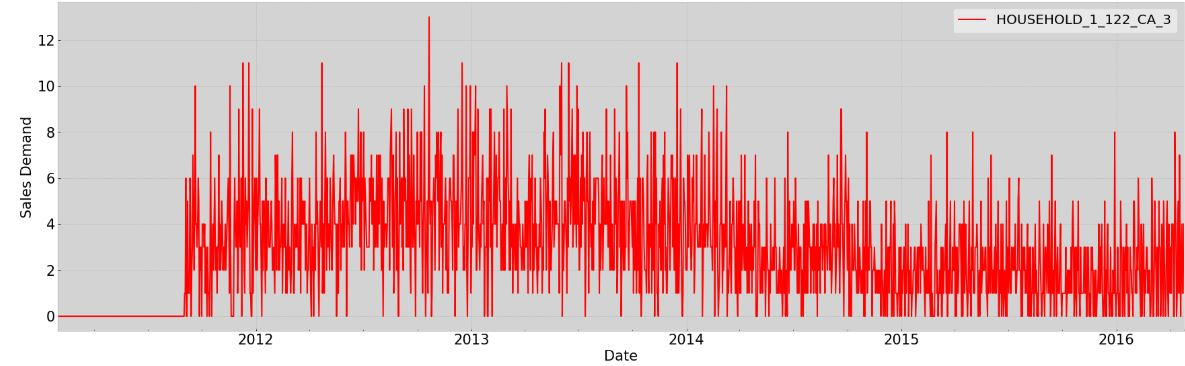

Or in a more schematic ilustriation 

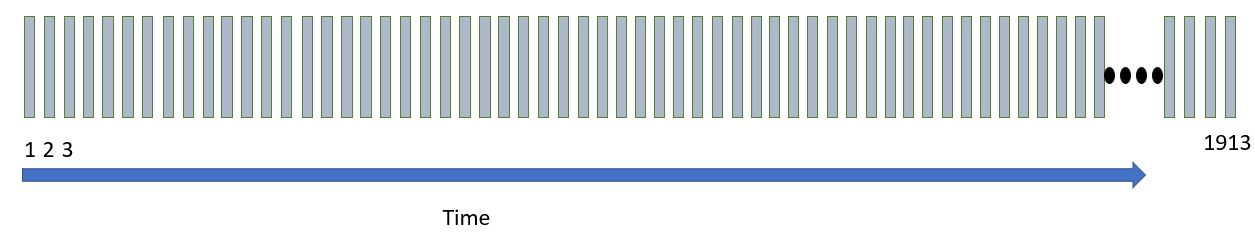

The Basic idea of Time Series prediction and RNN (Recurrent Neural Network) is to re-arrange the data 
into windows of sequences, and labels. 
For this example, I will use a window or a sequence of 28 samples (28 days ) 
So the data should look like this series.

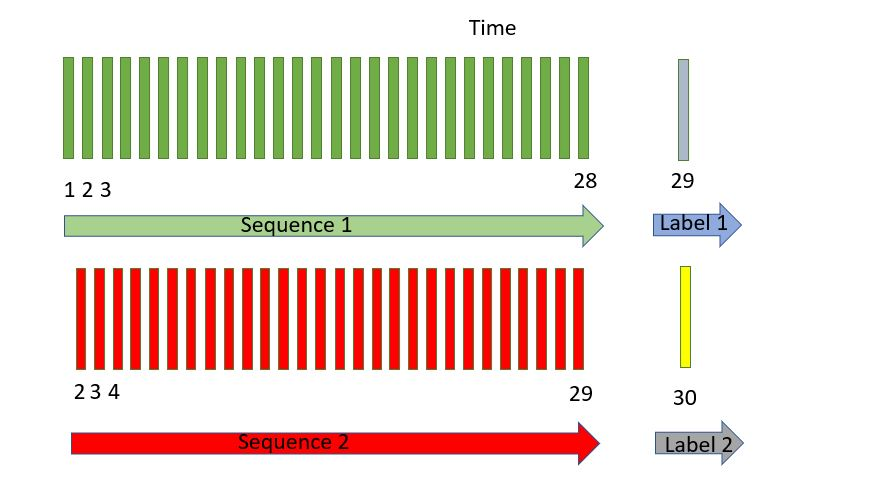

We create a sliding window which builds sequences and labels.
In our case, we have sequences of 28 days, that will use to predict the next day.

In [ ]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

Lets see the shape of our data

In [ ]:
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

## Pytorch Tensors 
Pytorch use tensors as the input to the model 
Variable is a wrapper to the tensor 
This kernel is only a preliminary starter, 

So I use the Variable wrapper
A more common way is to train with batches and use the dataset class
But this is for later.

If you want to learn more about Tensors 
Read this tutorial 

https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html

We also split the data to train and testing or validation sets.
There are multiple methods to do this (hold one-off, Cross-Validation),
but for Time Series, this needs careful and gentile planning.
For simplicity, at this stage, We will split the data for the training set and a test set

In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

So we got :
* 1262 sets of 28 samples each as the features (X) and 1262 labels as our target(y) in the training set 
* 622 sets of 28 samples with 622 labels in our tests set 

You can see that in Pytorch the tensor dimensions are opposite to the NumPy dimensions 

# Simple LSTM model <a id="6"></a>
In this section, we create the Pytorch LSTM model.
The Model has one LST layer and one dense input layer.
You can read all the details about the LSTM 
(Versus RNN) - at the link, I provided above 
The picture of one cell is taken from that blog.

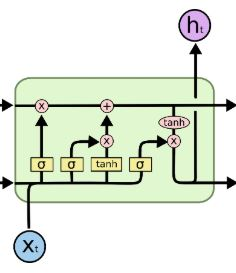

Note: that Pytorch has the nn.LSTM  function and nn.LSTMCell.
From what I have read you should use the nn.LSTM . 
It is the layer that will automatically create multiple LSTM layer,
and it seems that it uses more efficiently the Cuda drivers 
you can see more in this discussion 
https://discuss.pytorch.org/t/nn-lstmcell-inside-nn-lstm/51189

The illustration below shoe a schematic of our simple LSTM net :
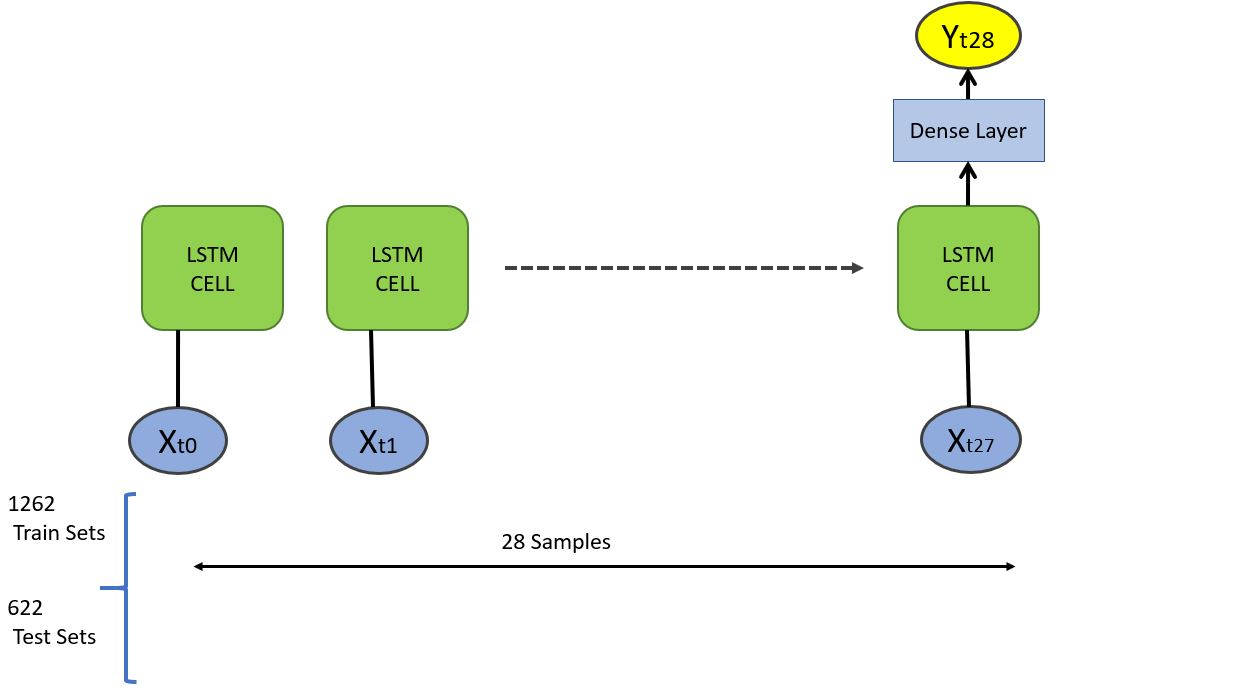

The following parameters are provided to the net
* Num-classes - is the number of output in this case 1
* Input size - we don't use batch, so we have one input (of 28 samples)
* Hidden layers, number of hidden layer in each cell, the more is better, but also will slow down the training
* Num layers - we have one layer of LSTM (layer we will increase it)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [ ]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
#####  Parameters  ######################
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))


## Predict on Entire Data Set 

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


In [ ]:

#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

### Test RMSE

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

# Multiple LSTM layers <a id="7"></a> 
We can Enhance the net by using multiple LSTM layers. 
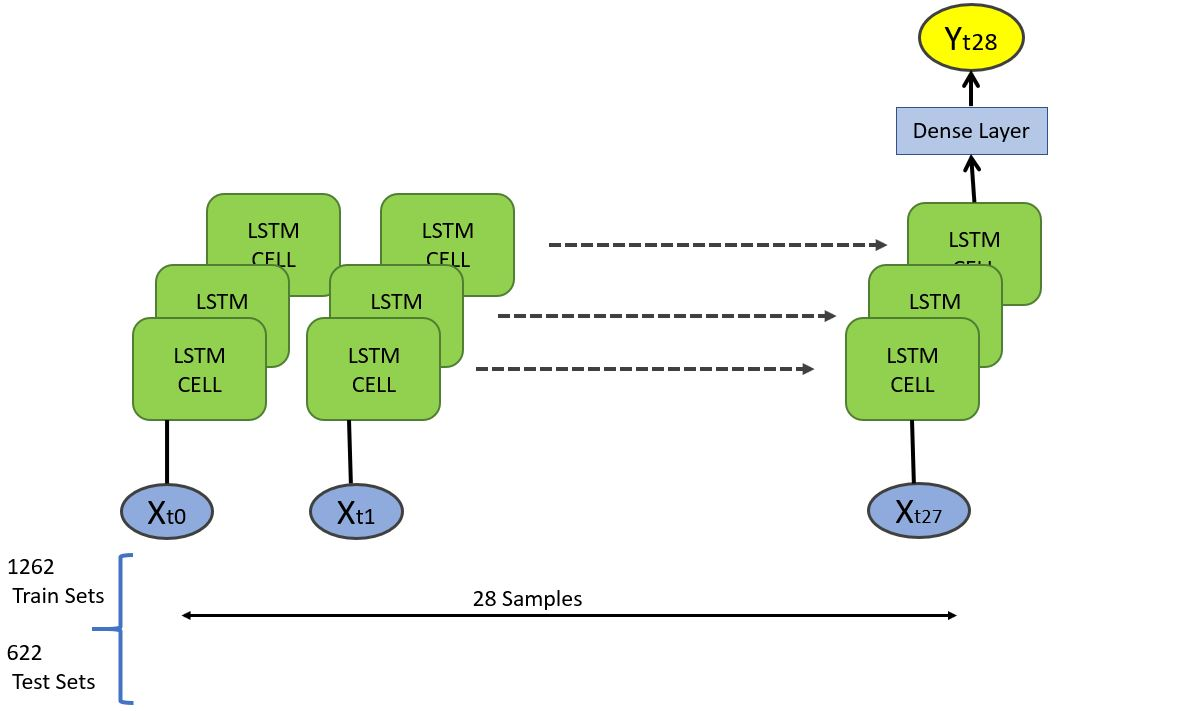

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out
    
   
        
       
        

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        


In [ ]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


In [ ]:

#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

### Test RMSE

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

# Add Features <a id="8"></a> 
So far we add only one feature - The Sales demand 
Now  let's add more features 

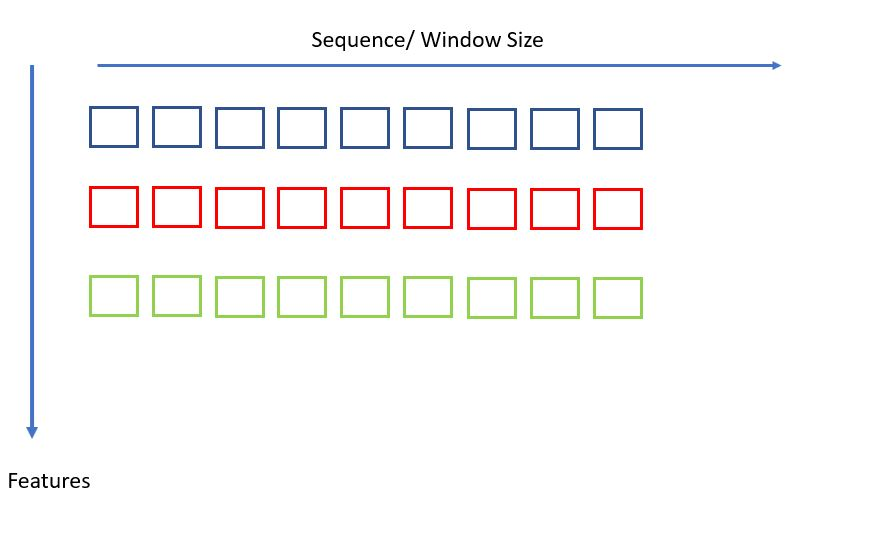

Features can be lags or rolling windows. It is easier to implement using data-frame Lag is just shifting the sales demand.

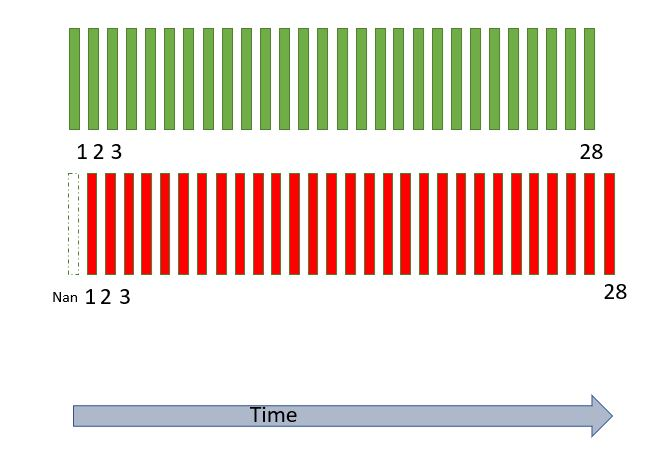

Rolling window is some calculation over a window (example mean )

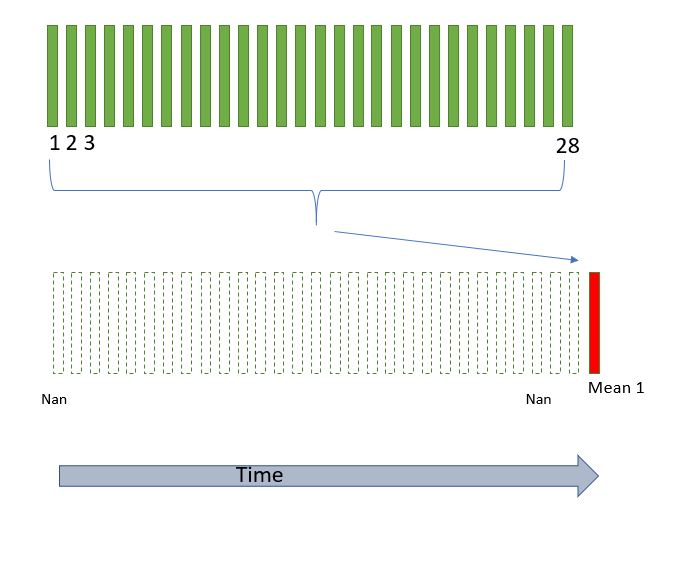

Now we can start again with the selected Time Series, Add some features and modify a bit our model and training.

In [ ]:
# Re-Use the Time Series we have selected earlier
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

## Lag features 

In [ ]:
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))


## Plot Lags
Let's Plot our lags 
it is a bit hard to see the small lags (as the Time Series containing few years), but for the longer lags 
such as 365, we can see the shift ...

In [ ]:
 
DF = DF.set_index([dates_list])
Product = "Time Series"

################Create Plot ##############################################
fig, axs = plt.subplots(6, 1, figsize=(33, 16))
axs = axs.flatten()
ax_idx = 0

for i in (0,1,7,14,28,365):
    if i == 0:
        ax = DF['sales'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product)

        ax_idx += 1
    else : 
        ax = DF[f'lag_{i}'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product+f'  Lag {i}')

        ax_idx += 1
    
   
   
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )

plt.tight_layout()
plt.show()


## Rolling windows 
For rolling windows, we will use mean and std (standard deviation)

In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

The lags and rolling windows created Nan values 
When I tried to train with Nan values, the loss was also Nan 
Need further understanding, but for now, I will replace the Nan by zero 

In [ ]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

## Normalize
Due to the multi-dimension, we need to adjust 
We can normalize the full Data-Frame. However, we need to do 
dummy normalize to our target (the sales) as our prediction will be 1D 



In [ ]:
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized.head()

## Day Of the Week 
This article : 

https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9

I have decided to try it as-is on the day of the week - So I will add four-vectors which describe the days of the week 

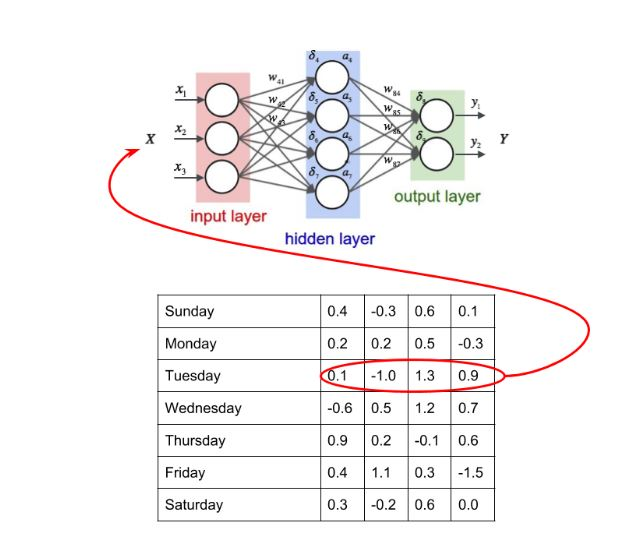

To use the day of the week - we will merge data from the calendar DF 

In [ ]:
DF_normlized = DF_normlized.reset_index()
DF_normlized = DF_normlized.rename(columns={'index':'date'})
DF_normlized.head()
DF_normlized['date'] = DF_normlized['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
DF_normlized = DF_normlized.merge(calendar_df[['date','weekday']],on='date')
DF_normlized.head()

In [ ]:
## Adding the embedded vectors 
DF_normlized['wd1'] =0
DF_normlized['wd2'] =0
DF_normlized['wd3'] =0
DF_normlized['wd4'] =0

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Sunday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Sunday']= 0.4 ,-0.3 ,0.6,0.1

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Monday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Monday']= 0.2 ,0.2 ,0.5,-0.3

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Tuesday'] ,DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Tuesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Tuesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Tuesday']= 0.1,-1.0,1.3,0.9

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Wednesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Wednesday']= -0.6,0.5,1.2,0.7

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Thursday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Thursday']= 0.9,0.2,-0.1,0.6

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Friday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Friday']= 0.4,1.1,0.3,-1.5


DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Saturday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Saturday']= 0.3,-0.2,0.6,0.0


Let's Compare one example again to verify that the normalization was done properly

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('rolling_mean_14 - Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(DF['rolling_mean_14']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(DF_normlized['rolling_mean_14']).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

## Multi-Dimensional Sliding Window

In [ ]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
###  For Multiple features                                                            ####
def sliding_windows_mutli_features(data, seq_length):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        _x = data[i:(i+seq_length),:] ## 16 columns for features  
        _y = data[i+seq_length,0] ## column 0 contains the labbel
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y).reshape(-1,1)

In [ ]:
# Select only the features and the target for prediction  
data_with_features = DF_normlized[["sales","lag_7","lag_1","lag_28","lag_365","rolling_mean_7",\
"rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28","rolling_mean_60","rolling_std_60",'lag_28','wd1','wd2','wd3','wd4']].to_numpy()             

#data_with_features = DF_normlized['sales'].to_numpy().reshape(-1,1)
data_with_features.shape

Create the sliding window data-set 

In [ ]:
x , y = sliding_windows_mutli_features(data_with_features,seq_length=28)
print("X_data shape is",x.shape)
print("y_data shape is",y.shape)

## Pytorch Tensor

In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

## LSTM model 
The model is similar to the previous one with  some enhancement at the output layers 

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.2)
       
        
        
        self.fc1 = nn.Linear(hidden_size,256)
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 128)
            
        self.bn2 = nn.BatchNorm1d(128,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.2)
        self.fc3= nn.Linear(128, 1)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        
        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)
        #print(out.size())
        return out
    
   

## Training 
Some enhancement  we save the best model (based on the lowest validation loss)

In [ ]:
num_epochs = 500
learning_rate = 1e-3
input_size = 18
hidden_size = 512
num_layers = 4
num_classes = 1

best_val_loss = 100

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=50, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    #scheduler.step()
    
    if vall_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
         best_val_loss = vall_loss.cpu().item()
        
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

## Predict

In [ ]:
######Prediction###############
lstm.load_state_dict(torch.load('best_model.pt'))

lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
print(data_predict.shape)
print(dataY_plot.shape)


## Inverse Normalize 
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


In [ ]:

#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

## RMSE - Test

In [ ]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

### What Next 
* Add more features 
* Calculate WRMSE 
* Change Loss function 
* Train MultiVarient series 
* Use batches 
* Add Convolotional Network 
* Use Cross Validiation 
* Create Submission 


## If you like the kernel, please vote, and this will encourage me to post more 


Also  I am happy to get comments or things that I need to fix.